In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import zlib
import xmltodict, json
from scipy import stats
from collections import namedtuple
sns.set_palette("tab10")
plt.figure(figsize=(15,10))

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [2]:
def parseDataEntry(entry):
    return {y[0]: None if y[1]=="" else float(y[1]) for y in [x.replace('"', "").split('=')for x in entry.split(' ')]}

In [3]:
def importMetaSpec(filename):
    with open(filename, "rb") as f:
        data = f.read()
        xmlBytes = zlib.decompress(data[4:])
    return xmlBytes.decode()

In [4]:
def WLStoDataFrame(filename):
    data = xmltodict.parse(importMetaSpec(filename))
    scanData = data["TWLSFiles"]["subs"]["TWLSFile"]["ScanData"]['TWLSScanDatas']["subs"]["TWLSScanData"]
    scanData = [parseDataEntry(x) for x in scanData]
    df = pd.DataFrame(scanData)
    df.ScanIndex = df.ScanIndex.astype(int)
    df.ItemIndex = df.ItemIndex.astype(int)
    df.rename(columns={"WaveLength":"Wavelength"}, inplace=True)
    
    scanParams = data["TWLSFiles"]["subs"]["TWLSFile"]["ScanParam"]["TWLSParams"]["subs"]['TWLSParam']["Threshold"]['TThresholds']["subs"]['TThreshold']
    scanParams = parseDataEntry(scanParams)
    
    chartParams = data["TWLSFiles"]["subs"]["TWLSFile"]["ScanParam"]["TWLSParams"]["subs"]['TWLSParam']["ChartParam"]["TChartParams"]["subs"]['TChartParam']
    chartParams = parseDataEntry(chartParams)
    
    return df, scanParams, chartParams

In [5]:
def copyBlank(data, scanIndex, blanks):
    newBlank = data.copy()[data.ScanIndex==scanIndex]
    newBlank.ScanIndex = max(blanks.ScanIndex)+1
    return blanks.append(newBlank), data[~(data.ScanIndex==scanIndex)]

In [6]:
def labelScans(listOfLabels, df):
    scans = sorted(df.ScanIndex.unique())
    try:
        assert len(scans)==len(listOfLabels)
    except AssertionError as e:
        print(f"There are {len(listOfLabels)} labels but {len(scans)} scans to label.")
        raise e
    print(list(df.ScanIndex.unique()))
    df["Label"] = df.ScanIndex.apply(lambda i: listOfLabels[scans.index(i)])

In [7]:
blanks, scanParams, chartParams = WLStoDataFrame("./data/blanks.WLS")

noCitrate, scanParams, chartParams = WLStoDataFrame("./data/no_citrate.WLS")
blanks, noCitrate = copyBlank(noCitrate, 1, blanks)


T1_E, scanParams, chartParams = WLStoDataFrame("./data/T1_E.WLS")
T2_E, scanParams, chartParams = WLStoDataFrame("./data/T2_E.WLS")
T1_T2, scanParams, chartParams = WLStoDataFrame("./data/T1_T2.WLS")
T1_titrate, scanParams, chartParams = WLStoDataFrame("./data/T1_titrate.WLS")
T2_titrate, scanParams, chartParams = WLStoDataFrame("./data/T2_titrate.WLS")

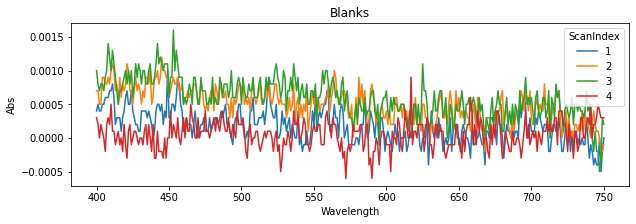

In [8]:
plt.figure(figsize=(10,3))
ax = sns.lineplot(x=blanks.Wavelength, y=blanks.Abs, data=blanks, hue=blanks.ScanIndex, palette="tab10")
ax.set_title(f"Blanks (n={len(blanks.ScanIndex.unique())})")
ax.set_title("Blanks")
plt.savefig("./figs/blanks.png", dpi=300)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


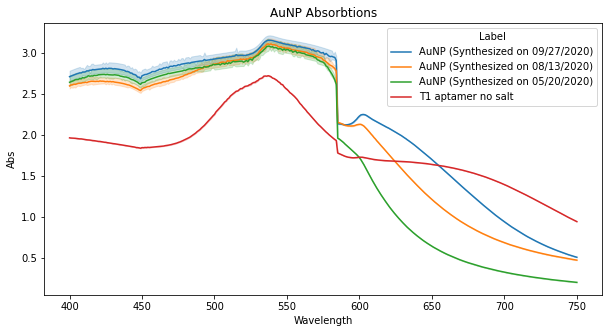

In [9]:
plt.figure(figsize=(10,5))
labelScans(["AuNP (Synthesized on 09/27/2020)", "AuNP (Synthesized on 08/13/2020)", "AuNP (Synthesized on 05/20/2020)", "AuNP (Synthesized on 09/27/2020)", "AuNP (Synthesized on 09/27/2020)", "AuNP (Synthesized on 08/13/2020)", "AuNP (Synthesized on 08/13/2020)", "AuNP (Synthesized on 05/20/2020)", "AuNP (Synthesized on 05/20/2020)", "T1 aptamer no salt", "T1 aptamer no salt"], noCitrate)
ax = sns.lineplot(x=noCitrate.Wavelength, y=noCitrate.Abs, data=noCitrate, hue=noCitrate.Label, palette="tab10")
ax.set_title("AuNP Absorbtions")
plt.savefig("./figs/aunps.png", dpi=300)

[1, 2, 3, 4]


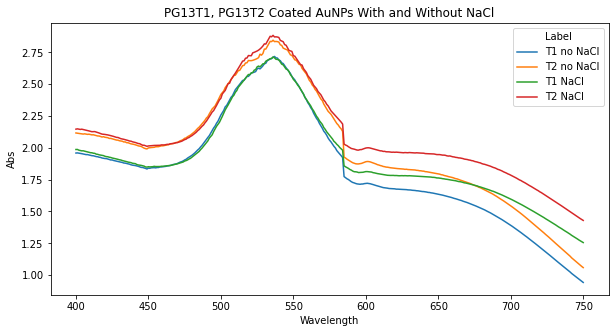

In [22]:
plt.figure(figsize=(10,5))
labelScans(["T1 no NaCl", "T2 no NaCl", "T1 NaCl", "T2 NaCl"], T1_T2)
ax = sns.lineplot(x=T1_T2.Wavelength, y=T1_T2.Abs, data=T1_T2, hue=T1_T2.Label, palette="tab10")
ax.set_title("PG13T1, PG13T2 Coated AuNPs With and Without NaCl")
plt.savefig("./figs/NaCl.png", dpi=300)

[1, 2, 3, 4, 5, 6, 7, 8]


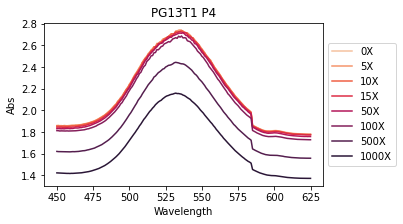

In [24]:
plt.figure(figsize=(5,3))
labelScans(["0X", "5X", "10X", "15X",
            "50X", "100X", "500X", "1000X"], T1_titrate)
ax = sns.lineplot(x=T1_titrate.Wavelength, y=T1_titrate.Abs, data=T1_titrate, hue=T1_titrate.Label, palette="rocket_r")
ax.set_title("PG13T1 P4")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig("./figs/P4T1.png", dpi=300, bbox_inches='tight')

In [25]:
def getByLabelAtWavelengths(inputDf, wavelengths):
    dfs = []
    display(inputDf)
    for wavelength in wavelengths:
        df = inputDf[inputDf.Wavelength==wavelength][["Abs", "Label"]].T
        df.columns = df.loc["Label"]
        df.drop("Label", inplace=True)
        df.rename({"Abs":wavelength}, inplace=True)
        dfs.append(df)
    df = dfs[0]
    for i in range(1, len(dfs)):
        df = df.append(dfs[i])
    return df
'''
df = getByLabelAtWavelengths(T1_titrate, [523, 625]).T
df["625/523"] = (df[625]/df[523]).astype(float)
df["uL Added"] = list(map(lambda x: int(x.replace("uL", "").replace("T1 +","")), df.index))
df["uL Added"] = df["uL Added"].astype(int)
display(df)
'''

'\ndf = getByLabelAtWavelengths(T1_titrate, [523, 625]).T\ndf["625/523"] = (df[625]/df[523]).astype(float)\ndf["uL Added"] = list(map(lambda x: int(x.replace("uL", "").replace("T1 +","")), df.index))\ndf["uL Added"] = df["uL Added"].astype(int)\ndisplay(df)\n'

In [26]:
def getRatioDf(dff, label1, label2):
    df = getByLabelAtWavelengths(dff, [523, 625]).T
    df["625/523"] = (df[625]/df[523]).astype(float)
    df["uL Added"] = list(map(lambda x: int(x.replace(label1, "").replace(label2,"")), df.index))
    df["uL Added"] = df["uL Added"].astype(int)
    return df

,ScanIndex,ItemIndex,Wavelength,Abs,Trans,Energy,Conc,PVPro,ItemMark,BrightEnergy,DarkEnergy,Amp,Label
0,1,1,625.0,1.7834,1.6468,0.0,0.0,0.0,None,35431.0,151.0,3.0,0X
1,1,2,624.0,1.7833,1.6469,0.0,0.0,0.0,None,35491.0,151.0,3.0,0X
2,1,3,623.0,1.7835,1.6463,0.0,0.0,0.0,None,35563.0,151.0,3.0,0X
3,1,4,622.0,1.7844,1.6429,0.0,0.0,0.0,None,35637.0,151.0,3.0,0X
4,1,5,621.0,1.7846,1.6420,0.0,0.0,0.0,None,35717.0,151.0,3.0,0X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,8,172,454.0,1.4206,3.7965,0.0,0.0,0.0,None,14006.0,151.0,3.0,1000X
1404,8,173,453.0,1.4215,3.7888,0.0,0.0,0.0,None,13770.0,151.0,3.0,1000X
1405,8,174,452.0,1.4216,3.7875,0.0,0.0,0.0,None,13537.0,151.0,3.0,1000X
1406,8,175,451.0,1.4233,3.7727,0.0,0.0,0.0,None,13298.0,151.0,3.0,1000X


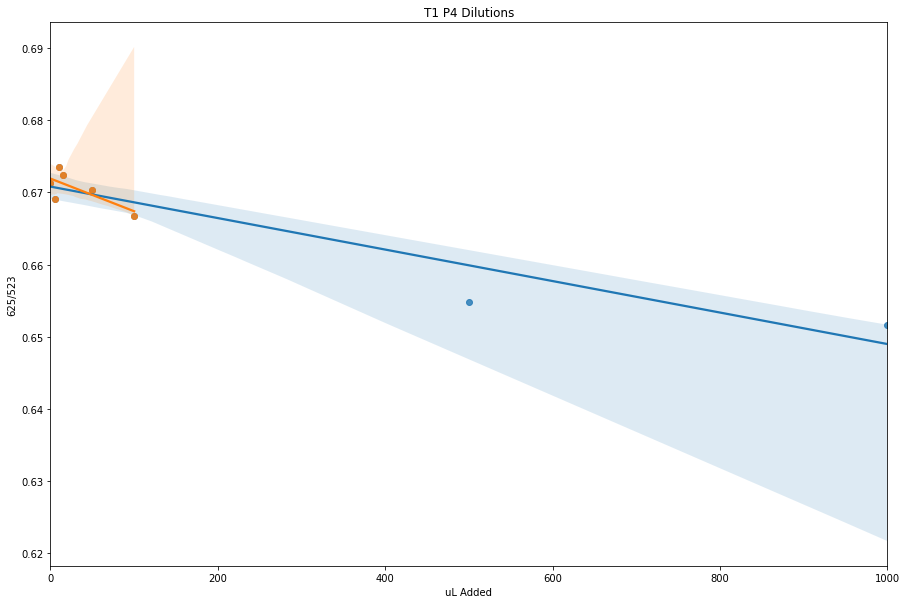

In [27]:
T1_ratios = getRatioDf(T1_titrate, "", "X")
T1_ratios
plt.figure(figsize=(15,10))
ax = sns.regplot(x="uL Added", y="625/523", data=T1_ratios)
ax = sns.regplot(x="uL Added", y="625/523", data=T1_ratios.loc["0X":"100X"])
ax.set_title("T1 P4 Dilutions")
plt.savefig("./figs/P4T1_line.png", dpi=300)

[1, 2, 3, 4, 5, 6, 7, 8]


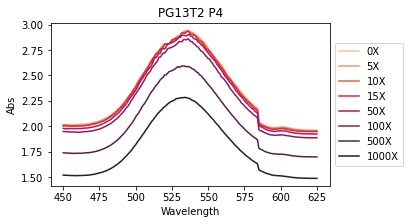

In [28]:
plt.figure(figsize=(5,3))
labelScans(["0X", "5X", "10X", "15X",
            "50X", "100X", "500X", "1000X"], T2_titrate)
ax = sns.lineplot(x=T2_titrate.Wavelength, y=T2_titrate.Abs, data=T2_titrate, hue=T2_titrate.Label, palette="rocket_r")
ax.set_title("PG13T2 P4")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig("./figs/P4T2.png", dpi=300, bbox_inches='tight')

,ScanIndex,ItemIndex,Wavelength,Abs,Trans,Energy,Conc,PVPro,ItemMark,BrightEnergy,DarkEnergy,Amp,Label
0,1,1,625.0,1.9647,1.0848,0.0,0.0,0.0,None,35180.0,151.0,3.0,0X
1,1,2,624.0,1.9632,1.0885,0.0,0.0,0.0,None,35246.0,151.0,3.0,0X
2,1,3,623.0,1.9643,1.0856,0.0,0.0,0.0,None,35339.0,151.0,3.0,0X
3,1,4,622.0,1.9643,1.0857,0.0,0.0,0.0,None,35427.0,151.0,3.0,0X
4,1,5,621.0,1.9643,1.0858,0.0,0.0,0.0,None,35516.0,151.0,3.0,0X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,8,172,454.0,1.5188,3.0283,0.0,0.0,0.0,None,13921.0,151.0,3.0,1000X
1404,8,173,453.0,1.5185,3.0301,0.0,0.0,0.0,None,13682.0,151.0,3.0,1000X
1405,8,174,452.0,1.5197,3.0223,0.0,0.0,0.0,None,13452.0,151.0,3.0,1000X
1406,8,175,451.0,1.5193,3.0245,0.0,0.0,0.0,None,13211.0,151.0,3.0,1000X


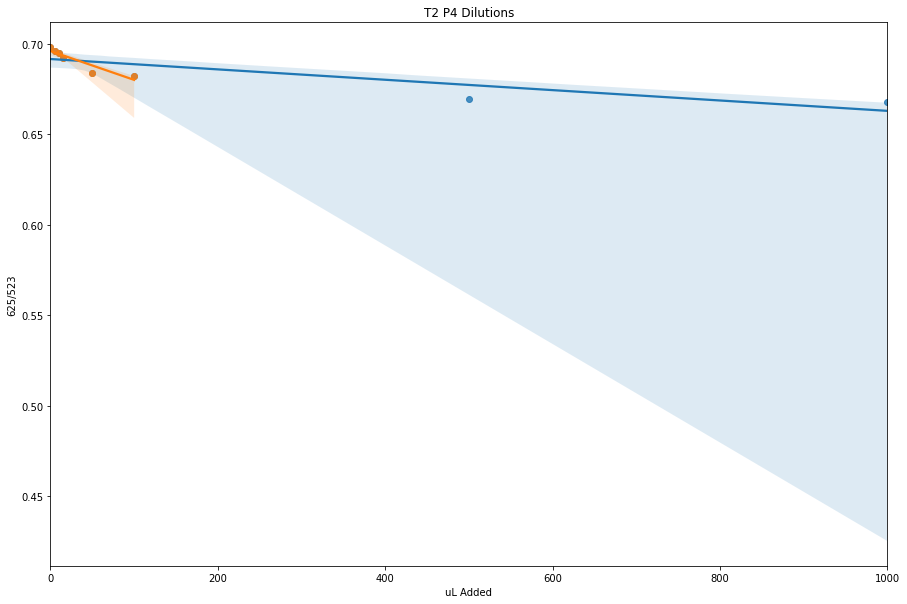

In [29]:
T2_ratios = getRatioDf(T2_titrate, "", "X")
T2_ratios
plt.figure(figsize=(15,10))
ax = sns.regplot(x="uL Added", y="625/523", data=T2_ratios)
ax = sns.regplot(x="uL Added", y="625/523", data=T2_ratios.loc["0X":"100X"])
ax.set_title("T2 P4 Dilutions")
plt.savefig("./figs/P4T2_line.png", dpi=300)

[1, 2, 3, 4, 5, 6, 7, 8]


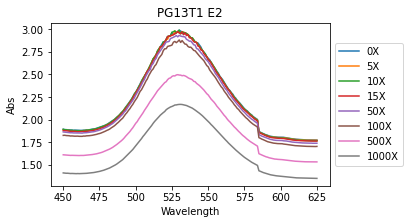

In [31]:
plt.figure(figsize=(5,3))
labelScans(["0X", "5X", "10X", "15X",
            "50X", "100X", "500X", "1000X"], T1_E)
ax = sns.lineplot(x=T1_E.Wavelength, y=T1_E.Abs, data=T1_E, hue=T1_E.Label, palette="tab10")
ax.set_title("PG13T1 E2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig("./figs/E2T1.png", dpi=300, bbox_inches='tight')

,ScanIndex,ItemIndex,Wavelength,Abs,Trans,Energy,Conc,PVPro,ItemMark,BrightEnergy,DarkEnergy,Amp,Label
0,1,1,625.0,1.7737,1.6838,0.0,0.0,0.0,None,35190.0,151.0,3.0,0X
1,1,2,624.0,1.7736,1.6843,0.0,0.0,0.0,None,35240.0,151.0,3.0,0X
2,1,3,623.0,1.7738,1.6833,0.0,0.0,0.0,None,35319.0,151.0,3.0,0X
3,1,4,622.0,1.7741,1.6824,0.0,0.0,0.0,None,35399.0,151.0,3.0,0X
4,1,5,621.0,1.7746,1.6805,0.0,0.0,0.0,None,35497.0,151.0,3.0,0X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,8,172,454.0,1.4049,3.9368,0.0,0.0,0.0,None,13944.0,151.0,3.0,1000X
1404,8,173,453.0,1.4064,3.9230,0.0,0.0,0.0,None,13712.0,151.0,3.0,1000X
1405,8,174,452.0,1.4061,3.9255,0.0,0.0,0.0,None,13474.0,151.0,3.0,1000X
1406,8,175,451.0,1.4075,3.9129,0.0,0.0,0.0,None,13236.0,151.0,3.0,1000X


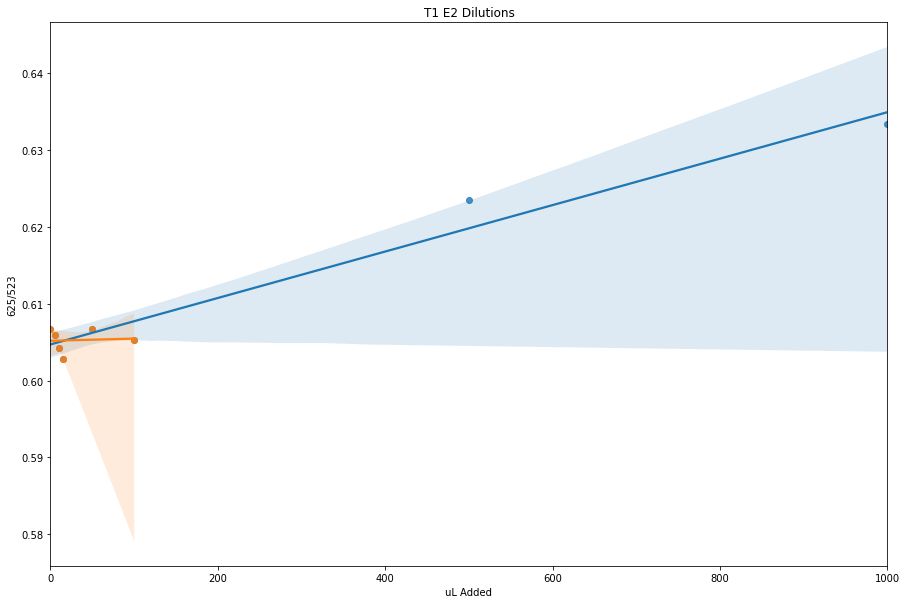

In [32]:
E2T1_ratios = getRatioDf(T1_E, "", "X")
E2T1_ratios
plt.figure(figsize=(15,10))
ax = sns.regplot(x="uL Added", y="625/523", data=E2T1_ratios)
ax = sns.regplot(x="uL Added", y="625/523", data=E2T1_ratios.loc["0X":"100X"])
ax.set_title("T1 E2 Dilutions")
plt.savefig("./figs/E2T1_line.png", dpi=300)

[1, 2, 3, 4, 5, 6, 7, 8]


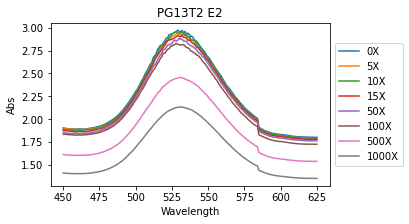

In [33]:
plt.figure(figsize=(5,3))
labelScans(["0X", "5X", "10X", "15X",
            "50X", "100X", "500X", "1000X"], T2_E)
ax = sns.lineplot(x=T2_E.Wavelength, y=T2_E.Abs, data=T2_E, hue=T2_E.Label, palette="tab10")
ax.set_title("PG13T2 E2")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig("./figs/E2T2.png", dpi=300, bbox_inches='tight')

,ScanIndex,ItemIndex,Wavelength,Abs,Trans,Energy,Conc,PVPro,ItemMark,BrightEnergy,DarkEnergy,Amp,Label
0,1,1,625.0,1.7997,1.5859,0.0,0.0,0.0,None,35209.0,151.0,3.0,0X
1,1,2,624.0,1.8004,1.5833,0.0,0.0,0.0,None,35268.0,151.0,3.0,0X
2,1,3,623.0,1.8000,1.5850,0.0,0.0,0.0,None,35356.0,151.0,3.0,0X
3,1,4,622.0,1.8010,1.5811,0.0,0.0,0.0,None,35442.0,151.0,3.0,0X
4,1,5,621.0,1.8005,1.5829,0.0,0.0,0.0,None,35528.0,151.0,3.0,0X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,8,172,454.0,1.4043,3.9417,0.0,0.0,0.0,None,13952.0,151.0,3.0,1000X
1404,8,173,453.0,1.4051,3.9346,0.0,0.0,0.0,None,13723.0,151.0,3.0,1000X
1405,8,174,452.0,1.4055,3.9313,0.0,0.0,0.0,None,13480.0,151.0,3.0,1000X
1406,8,175,451.0,1.4077,3.9108,0.0,0.0,0.0,None,13243.0,151.0,3.0,1000X


KeyError: 'T2 +0 uL E2'

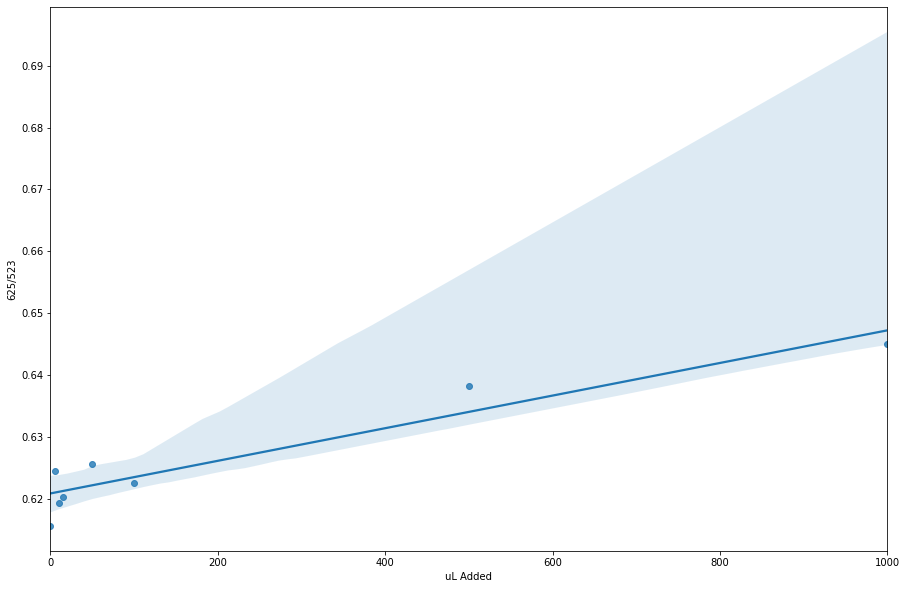

In [34]:
E2T2_ratios = getRatioDf(T2_E, "", "X")
E2T2_ratios
plt.figure(figsize=(15,10))
ax = sns.regplot(x="uL Added", y="625/523", data=E2T2_ratios)
ax = sns.regplot(x="uL Added", y="625/523", data=E2T2_ratios.loc["T2 +0 uL E2":"T2 + 100 uL E2"])
ax.set_title("T2 E2 Dilutions")
plt.savefig("./figs/E2T2_line.png", dpi=300)

In [35]:
ratios = [x.copy() for x in [E2T1_ratios, E2T2_ratios, T1_ratios, T2_ratios]]

In [36]:
aunpConc = [3/(3+(x/1000)) for x in [0,5,10,15,50,100,500,1000]]
for r in ratios:
    r["AuNP Conc"] = aunpConc
    r["523 (adj.)"] = (r[523]/r["AuNP Conc"]).astype(float)
    r["625 (adj.)"] = (r[625]/r["AuNP Conc"]).astype(float)
    r["523/625 (adj.)"] = (r[523]/r[625]).astype(float)
    r["625/523 (adj.)"] = (r[523]/r[625]).astype(float)
    
    r["523/625 (adj.)"] = r["523/625 (adj.)"]-r.iloc[0]["523/625 (adj.)"]

In [37]:
for r in ratios[0:2]:
    #https://www.wolframalpha.com/input/?i=(0.0041g-0.0015g)*(356.5g%2Fmol)^-1*(10%2F1500)(10%2F1500)(10%2F1500)(580%2F1000)(100%2F1000)*1.5mL
    r["E2 Conc (pM)"] = [(0.41725*x)/(3+(x/1000)) for x in [0,5,10,15,50,100,500,1000]]
    r["E2 Conc (pM)"] = r["E2 Conc (pM)"].astype(float)
    r["Titrant"]="E2"
for r in ratios[2:]:
    #https://www.wolframalpha.com/input/?i=((1g%2F70mg*314g%2Fmol)^-1*4mg%2F1mL*10^-8)*5uL+to+fmol = 0.04459fmol
    r["P4 Conc (pM)"] = [(0.04459*x)/(3+(x/1000)) for x in [0,5,10,15,50,100,500,1000]]
    r["P4 Conc (pM)"] = r["P4 Conc (pM)"].astype(float)
    r["Titrant"]="P4"


In [38]:
for r in ratios:
    display(r)

,523,625,625/523,uL Added,AuNP Conc,523 (adj.),625 (adj.),523/625 (adj.),625/523 (adj.),E2 Conc (pM),Titrant
Label,,,,,,,,,,,
0X,2.9234,1.7737,0.606725,0,1.000000,2.923400,1.773700,0.000000,1.648193,0.000000,E2
5X,2.9234,1.7715,0.605972,5,0.998336,2.928272,1.774452,0.002047,1.650240,0.694260,E2
10X,2.9234,1.7664,0.604228,10,0.996678,2.933145,1.772288,0.006811,1.655005,1.386213,E2
15X,2.9234,1.7621,0.602757,15,0.995025,2.938017,1.770911,0.010850,1.659043,2.075871,E2
50X,2.8655,1.7384,0.606666,50,0.983607,2.913258,1.767373,0.000162,1.648355,6.840164,E2
100X,2.8142,1.7032,0.605216,100,0.967742,2.908007,1.759973,0.004109,1.652302,13.459677,E2
500X,2.4568,1.5317,0.623453,500,0.857143,2.866267,1.786983,-0.044224,1.603969,59.607143,E2
1000X,2.1301,1.3492,0.633397,1000,0.750000,2.840133,1.798933,-0.069406,1.578787,104.312500,E2


,523,625,625/523,uL Added,AuNP Conc,523 (adj.),625 (adj.),523/625 (adj.),625/523 (adj.),E2 Conc (pM),Titrant
Label,,,,,,,,,,,
0X,2.9237,1.7997,0.615556,0,1.000000,2.923700,1.799700,0.000000,1.624549,0.000000,E2
5X,2.8658,1.7897,0.624503,5,0.998336,2.870576,1.792683,-0.023275,1.601274,0.694260,E2
10X,2.8938,1.792,0.619255,10,0.996678,2.903446,1.797973,-0.009705,1.614844,1.386213,E2
15X,2.8658,1.7776,0.620281,15,0.995025,2.880129,1.786488,-0.012375,1.612174,2.075871,E2
50X,2.8147,1.7609,0.625608,50,0.983607,2.861612,1.790248,-0.026105,1.598444,6.840164,E2
100X,2.769,1.7239,0.622571,100,0.967742,2.861300,1.781363,-0.018307,1.606242,13.459677,E2
500X,2.4072,1.5362,0.638169,500,0.857143,2.808400,1.792233,-0.057565,1.566983,59.607143,E2
1000X,2.0923,1.3497,0.645080,1000,0.750000,2.789733,1.799600,-0.074352,1.550196,104.312500,E2


,523,625,625/523,uL Added,AuNP Conc,523 (adj.),625 (adj.),523/625 (adj.),625/523 (adj.),P4 Conc (pM),Titrant
Label,,,,,,,,,,,
0X,2.6566,1.7834,0.671309,0,1.000000,2.656600,1.783400,0.000000,1.489627,0.000000,P4
5X,2.6566,1.7774,0.669051,5,0.998336,2.661028,1.780362,0.005029,1.494655,0.074193,P4
10X,2.6402,1.7781,0.673472,10,0.996678,2.649001,1.784027,-0.004783,1.484843,0.148140,P4
15X,2.6402,1.7752,0.672373,15,0.995025,2.653401,1.784076,-0.002358,1.487269,0.221841,P4
50X,2.6245,1.7594,0.670375,50,0.983607,2.668242,1.788723,0.002075,1.491702,0.730984,P4
100X,2.5945,1.73,0.666795,100,0.967742,2.680983,1.787667,0.010084,1.499711,1.438387,P4
500X,2.3814,1.5594,0.654825,500,0.857143,2.778300,1.819300,0.037499,1.527126,6.370000,P4
1000X,2.1078,1.3735,0.651627,1000,0.750000,2.810400,1.831333,0.044993,1.534620,11.147500,P4


,523,625,625/523,uL Added,AuNP Conc,523 (adj.),625 (adj.),523/625 (adj.),625/523 (adj.),P4 Conc (pM),Titrant
Label,,,,,,,,,,,
0X,2.8136,1.9647,0.698287,0,1.000000,2.813600,1.964700,0.000000,1.432076,0.000000,P4
5X,2.8136,1.9579,0.695870,5,0.998336,2.818289,1.961163,0.004974,1.437050,0.074193,P4
10X,2.8136,1.9545,0.694662,10,0.996678,2.822979,1.961015,0.007474,1.439550,0.148140,P4
15X,2.8136,1.9478,0.692280,15,0.995025,2.827668,1.957539,0.012425,1.444501,0.221841,P4
50X,2.8136,1.9243,0.683928,50,0.983607,2.860493,1.956372,0.030066,1.462142,0.730984,P4
100X,2.7678,1.8883,0.682239,100,0.967742,2.860060,1.951243,0.033687,1.465763,1.438387,P4
500X,2.5373,1.6993,0.669728,500,0.857143,2.960183,1.982517,0.061068,1.493144,6.370000,P4
1000X,2.23,1.4887,0.667578,1000,0.750000,2.973333,1.984933,0.065875,1.497951,11.147500,P4


In [39]:
for r in ratios[0:2]:
    r["P4 Conc (pM)"] = 0
for r in ratios[2:]:
    r["E2 Conc (pM)"] = 0

In [40]:
ratios[0]["Aptamer"] = "T1"
ratios[2]["Aptamer"] = "T1"
ratios[1]["Aptamer"] = "T2"
ratios[3]["Aptamer"] = "T2"

In [41]:
df = ratios[0]
for r in ratios[1:]:
    df = df.append(r)
df.index = df.Aptamer+df.Titrant#+df["uL Added"].astype(str)
df

,523,625,625/523,uL Added,AuNP Conc,523 (adj.),625 (adj.),523/625 (adj.),625/523 (adj.),E2 Conc (pM),Titrant,P4 Conc (pM),Aptamer
T1E2,2.9234,1.7737,0.606725,0,1.000000,2.923400,1.773700,0.000000,1.648193,0.000000,E2,0.000000,T1
T1E2,2.9234,1.7715,0.605972,5,0.998336,2.928272,1.774452,0.002047,1.650240,0.694260,E2,0.000000,T1
T1E2,2.9234,1.7664,0.604228,10,0.996678,2.933145,1.772288,0.006811,1.655005,1.386213,E2,0.000000,T1
T1E2,2.9234,1.7621,0.602757,15,0.995025,2.938017,1.770911,0.010850,1.659043,2.075871,E2,0.000000,T1
T1E2,2.8655,1.7384,0.606666,50,0.983607,2.913258,1.767373,0.000162,1.648355,6.840164,E2,0.000000,T1
T1E2,2.8142,1.7032,0.605216,100,0.967742,2.908007,1.759973,0.004109,1.652302,13.459677,E2,0.000000,T1
T1E2,2.4568,1.5317,0.623453,500,0.857143,2.866267,1.786983,-0.044224,1.603969,59.607143,E2,0.000000,T1
T1E2,2.1301,1.3492,0.633397,1000,0.750000,2.840133,1.798933,-0.069406,1.578787,104.312500,E2,0.000000,T1
T2E2,2.9237,1.7997,0.615556,0,1.000000,2.923700,1.799700,0.000000,1.624549,0.000000,E2,0.000000,T2
T2E2,2.8658,1.7897,0.624503,5,0.998336,2.870576,1.792683,-0.023275,1.601274,0.694260,E2,0.000000,T2


In [42]:
df = df[df["uL Added"]<600]

In [43]:
def getfit(X,Y,df):
    y=df[Y]
    x=df[X]
    values = ["slope", "intercept", "r", "pvalue", "stderr"]
    Fit = namedtuple("Fit", values)
    return Fit(*list(stats.linregress(x,y)))
#getfit("x", "y", pd.DataFrame({"x":[1,2,3], "y":[2,3,4]}))

[(0, 'T1P4'), (1, 'T1E2'), (2, 'T2E2'), (3, 'T2P4')]

Titrations of P4/E2 in AuNP Solutions doped with T1 or T2 Aptamers


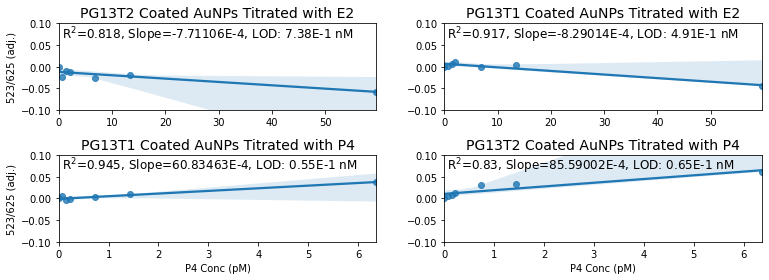

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(11, 4, forward=True)

tests = list(set(df.index))
display(list(enumerate(tests)))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        l = {0:{0:2, 1:1}, 1:{0:0, 1:3}}[i][j]
        dff = df.loc[tests[l]]
        x=dff.iloc[0]["Titrant"]+" Conc (pM)"
        y="523/625 (adj.)"
        sns.regplot(x=dff.iloc[0]["Titrant"]+" Conc (pM)", y="523/625 (adj.)", data=dff, ax=col)
        if i==0: col.set_xlabel("")
        if j==1: col.set_ylabel("")
        col.set_ylim(-0.1,0.1)
        fit = getfit(x,y,dff)
        lod = getfit(y,x,dff).stderr * 0.001 * 3.3
        col.set_title(tests[l][0:2].replace("T", "PG13T") + " Coated AuNPs Titrated with " + tests[l][2:], fontsize=14)
        col.text(0.01, 0.99, 
                 f"R$^2$={round(fit.r**2,3)}, Slope={str(round(fit.slope*10**4,5))}E-4, LOD: {round(lod*10,2)}E-1 nM", 
                 fontsize=12,
                 horizontalalignment='left',verticalalignment='top', transform=col.transAxes)
print("Titrations of P4/E2 in AuNP Solutions doped with T1 or T2 Aptamers")
fig.tight_layout()
plt.savefig("./figs/final-fig.png", dpi=300, transparent=True)